<a href="https://colab.research.google.com/github/nickxir12/PatRec_Project_2024-2025/blob/main/MNIST_code/MNIST_sample_complexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Experimenting with depth - filtering  code for MNIST dataset
#   Omada 2 -- Grokfast experiments

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# from google.colab import files
# files.upload()


In [5]:
!ls /content/drive/MyDrive/PatRec_Project_Shared_Folder/

Algorithmic_code  MNIST_code	  __pycache__  requirements.txt
grokfast.py	  _Presentations  QM9_code     results


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/PatRec_Project_Shared_Folder')

In [8]:
!pip install -r /content/drive/MyDrive/PatRec_Project_Shared_Folder/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


In [9]:
import random
import time
import math
import argparse
from argparse import ArgumentParser
from collections import defaultdict
from itertools import islice
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision
from typing import List, Optional, Dict, Literal
from collections import deque


In [11]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [40]:
def compute_accuracy(model, dataset, device, N=None):
    """Utility to compute accuracy on a given dataset."""
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    correct = 0
    total = 0
    #       Will have to fix below probably
    def custom_collate_fn(batch):
      """Custom collate function to handle extra fields in the dataset."""
      images, labels, _, _ = zip(*batch)  # Ignore the indices and extra_fields for loss computation
      images = torch.stack(images)  # Stack images into a single tensor
      labels = torch.tensor(labels)  # Convert labels to a tensor
      return images, labels

    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn)

    for x, y in loader:  # Unpack index and extra_fields as well
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            predictions = outputs.argmax(dim=1)
        correct += (predictions == y).sum().item()
        total += y.size(0)
        if N is not None and total >= N:
            break
    return correct / total

def compute_loss(model, dataset, loss_function_name, device, N=None):
    """Utility to compute the average loss on a given dataset."""
    loss_fn = loss_function_dict[loss_function_name]()
    def custom_collate_fn(batch):
        """Custom collate function to handle extra fields in the dataset."""
        images, labels, _, _ = zip(*batch)  # Ignore the indices and extra_fields for loss computation
        images = torch.stack(images)  # Stack images into a single tensor
        labels = torch.tensor(labels)  # Convert labels to a tensor
        return images, labels

    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn)

    total_loss = 0.0
    count = 0
    one_hots = torch.eye(10, device=device)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            if loss_function_name == 'CrossEntropy':
                loss = loss_fn(outputs, y)
            elif loss_function_name == 'MSE':
                loss = loss_fn(outputs, one_hots[y])
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        count += batch_size
        if N is not None and count >= N:
            break
    return total_loss / count



In [14]:
optimizer_dict = {
    'AdamW': torch.optim.AdamW,
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

activation_dict = {
    'ReLU': nn.ReLU,
    'Tanh': nn.Tanh,
    'Sigmoid': nn.Sigmoid,
    'GELU': nn.GELU
}

loss_function_dict = {
    'MSE': nn.MSELoss,
    'CrossEntropy': nn.CrossEntropyLoss
}

In [15]:
import os
# Ensure the 'results' directory exists
results_dir = "/content/drive/MyDrive/PatRec_Project_Shared_Folder/results/MNIST"
dataset_path = '/content/drive/MyDrive/PatRec_Project_Shared_Folder/MNIST_code/MNIST_data'

In [136]:
import torch
import torchvision

from torch.utils.data import Dataset

#         Added extra fields to keep ema_gra and history
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None,
                 target_transform=None, download=False):
        super().__init__(root, train=train, transform=transform,
                         target_transform=target_transform, download=download)
        self.extra_fields = [{ "ema_grad": 0.0,         # EMA of the gradient (of average of all selected gradients) at Present time
                                "metric_history": []    # List to store value of grads(average of grads of some seletced parameters) (or could be just gradient - difference from EMA(thats why I use ema_grad))
                               } for _ in range(len(self.data))]

    def __getitem__(self, index):
        """
        Override to return (image, label, index, extra_field).
        """
        img, target = super().__getitem__(index)
        extra_field = self.extra_fields[index]
        return img, target, index, extra_field

    def update_fields(self, indices, grad_stats,ema_alpha=0.9):
        """
        Update the extra fields for specified dataset indices.
        """

        for idx, grad  in zip(indices, grad_stats):
          # Update EMA
          sample_field = self.extra_fields[idx]

          current_ema = sample_field["ema_grad"]
          updated_ema = ema_alpha * current_ema + (1 - ema_alpha) * grad
          sample_field["ema_grad"] = updated_ema

          # Compute and store the metric: (current gradient - EMA)
          #metric = grad - updated_ema
          sample_field["metric_history"].append(grad)

          #print(f"After update: {self.extra_fields[idx]}")

In [32]:
def custom_collate_fn(batch):
    images, labels, indices, extra_fields = zip(*batch)
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return images, labels, indices, extra_fields



In [128]:
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.autograd import grad

def main(args):
    log_freq = math.ceil(args.optimization_steps / 150)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32
    one_hots = torch.eye(10, 10).to(device)

    torch.set_default_dtype(dtype)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    random.seed(args.seed)
    np.random.seed(args.seed)

    #                                 Load dataset
    #   -------------------------------------------------------------------------------   #

    #ATTEMPT2
    base_dataset = MyMNIST(
        root=dataset_path,
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True
    )
    # Create indices & stratify
    train_indices = list(range(len(base_dataset)))
    train_labels = [base_dataset.targets[i].item() for i in train_indices]

    args.train_points = 1000
    # Use train_test_split with stratification to randomly select a specified number of samples (args.train_points)
    stratified_indices, _ = train_test_split(
        train_indices,
        train_size=args.train_points,
        stratify=train_labels,
        random_state=args.seed
    )

    train_subset = torch.utils.data.Subset(base_dataset, stratified_indices)
    train_loader = DataLoader(train_subset, batch_size=args.batch_size, shuffle=True,collate_fn=custom_collate_fn)

    test_dataset = MyMNIST(
        root=dataset_path,
        train=False,
        transform=torchvision.transforms.ToTensor(),
        download=True
    )

    # We'll just use the full test dataset
    test = test_dataset

    activation_fn = activation_dict[args.activation]

    #                                   Create model
    #   -------------------------------------------------------------------------------   #

    layers = [nn.Flatten()]
    for i in range(args.depth):
        if i == 0:
            layers.append(nn.Linear(784, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            layers.append(nn.Linear(args.width, 10))
        else:
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)
    with torch.no_grad():
        for p in mlp.parameters():
            p.data = args.initialization_scale * p.data
    nparams = sum([p.numel() for p in mlp.parameters() if p.requires_grad])
    print(f'Number of parameters: {nparams}')

    # create optimizer
    assert args.optimizer in optimizer_dict, f"Unsupported optimizer choice: {args.optimizer}"
    optimizer = optimizer_dict[args.optimizer](mlp.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # define loss function
    assert args.loss_function in loss_function_dict
    loss_fn = loss_function_dict[args.loss_function]()

    # Initialize EMA and metric history for each sample
    gradient_ema = [0.0 for _ in range(len(train_subset))]
    gradient_metric_history = [[] for _ in range(len(train_subset))]
    ema_alpha = 0.9  # Exponential moving average factor


    #                           Start Training below
    #   -------------------------------------------------------------------------------   #
    steps, log_steps, train_losses, train_accuracies, test_losses, test_accuracies = 0, [], [], [], [], []
    one_hots = torch.eye(10, 10).to(device)
    os.makedirs(results_dir, exist_ok=True)

    with tqdm(total=args.optimization_steps, dynamic_ncols=True) as pbar:

        reached_early_stop = False  # Flag to indicate early stopping
        steps_to_reach_val_acc = None  # Variable to store steps for 0.95 validation accuracy

        stable_threshold = 100  # Number of steps the validation accuracy must remain > 0.85
        stable_steps = 0  # Counter for steps validation accuracy remains above 0.85

        for batch in islice(cycle(train_loader), args.optimization_steps):
            x, labels, indices, extra_fields = batch
            do_log = (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0
            if do_log:
                train_losses.append(compute_loss(mlp, train_subset, args.loss_function, device, N=len(train_subset)))
                train_accuracies.append(compute_accuracy(mlp, train_subset, device, N=len(train_subset)))
                test_losses.append(compute_loss(mlp, test, args.loss_function, device, N=len(test)))
                test_accuracies.append(compute_accuracy(mlp, test, device, N=len(test)))
                log_steps.append(steps)
                pbar.set_description(
                "Loss: {0:1.1e}|{1:1.1e}. Acc: {2:2.1f}%|{3:2.1f}%".format(
                    train_losses[-1],
                    test_losses[-1],
                    train_accuracies[-1] * 100,
                    test_accuracies[-1] * 100,
                )
            )

            x, labels = x.to(device), labels.to(device)
            y = mlp(x.to(device))
            if args.loss_function == 'CrossEntropy':
                # Use integer labels for CrossEntropyLoss
                loss = loss_fn(y, labels)
            elif args.loss_function == 'MSE':
                loss = loss_fn(y, one_hots[labels])

            optimizer.zero_grad()
            loss.backward(create_graph=True)

            # -----------------------------------------------------------------
            #   Gradient Stats: Capture grads for each sample
            # -----------------------------------------------------------------
            # Compute per-sample gradients for a specific layer
            target_layer = list(mlp.parameters())[0]  # Example: first layer weights
            per_sample_grads = grad(loss, target_layer, create_graph=False, retain_graph=True)[0]  # Shape: [batch_size, *layer_shape]

            # Aggregate gradients across samples - Average gradient for every sample
            batch_mean_grads = per_sample_grads.view(per_sample_grads.size(0), -1).mean(dim=1)  # Shape: [batch_size]

            # Update EMA and metrics for each sample
            for subset_idx, original_idx in enumerate(indices):
                #Update with value of average across all parameters
                train_subset.dataset.update_fields([original_idx], [batch_mean_grads[subset_idx]], ema_alpha)

            optimizer.step()

            test_acc = test_accuracies[-1] if len(test_accuracies) > 0 else 0
            # Check for early stopping conditions
            if test_acc >= 0.95 and steps_to_reach_val_acc is None:
                steps_to_reach_val_acc = steps  # Record the first step reaching 0.95 validation accuracy

            if test_acc > 0.9:
                stable_steps += 1
            else:
                stable_steps = 0  # Reset counter if accuracy drops below 0.9

            if stable_steps >= stable_threshold and test_acc >= 0.95:
                reached_early_stop = True
                print(f"Validation accuracy of 0.95 reached and remained > 0.9 for {stable_threshold} steps at step {steps}")


            steps += 1
            pbar.update(1)

    # Save results
    results_filename = os.path.join(results_dir, f"pt/mnist_{args.label}.pt")
    torch.save({
        'its': log_steps,
        'train_acc': train_accuracies,
        'train_loss': train_losses,
        'val_acc': test_accuracies,
        'val_loss': test_losses,
        'steps_to_reach': steps_to_reach_val_acc
    }, results_filename)

    return train_subset, steps_to_reach_val_acc


In [18]:
import sys
from argparse import ArgumentParser

# Remove the extra arguments passed by the Jupyter Notebook kernel
sys.argv = ['']

In [88]:
#     Same as used in paper of Grokfast
args = argparse.Namespace(
    train_points=1000,
    optimization_steps=100,
    batch_size=200,
    loss_function="MSE",
    optimizer="AdamW",
    weight_decay=0.01,
    lr=1e-3,
    initialization_scale=8.0,
    download_directory=".",
    depth=3,
    width=200,
    activation="ReLU",
    seed=42,
    label="experiment_all_samples"
)


In [138]:
# Call the training function
train_subset, steps_to_reach_val_acc= main(args)


Number of parameters: 199210


  0%|          | 0/100 [00:00<?, ?it/s]

In [139]:
for idx in train_subset.indices[:10]:  # Check the first 10 indices of the subset
    print(train_subset.dataset.extra_fields[idx])


{'ema_grad': tensor(0.0068), 'metric_history': [tensor(0.5293), tensor(0.1123), tensor(-0.2146), tensor(-0.0141), tensor(0.0838), tensor(0.0068), tensor(-0.0102), tensor(-0.0155), tensor(0.0123), tensor(0.0230), tensor(-0.0051), tensor(0.0137), tensor(0.0045), tensor(0.0049), tensor(-0.0005), tensor(0.0032), tensor(0.0219), tensor(-0.0067), tensor(-0.0058), tensor(-0.0220)]}
{'ema_grad': tensor(0.0013), 'metric_history': [tensor(0.0217), tensor(0.1098), tensor(0.0318), tensor(0.0028), tensor(-0.0122), tensor(-0.0312), tensor(-0.0008), tensor(-0.0105), tensor(0.0264), tensor(0.0005), tensor(-0.0014), tensor(-0.0144), tensor(0.0013), tensor(0.0241), tensor(0.0098), tensor(-0.0086), tensor(-0.0150), tensor(0.0052), tensor(0.0007), tensor(-0.0088)]}
{'ema_grad': tensor(0.0025), 'metric_history': [tensor(-0.0891), tensor(-0.0078), tensor(0.1221), tensor(0.0268), tensor(0.0201), tensor(-0.0110), tensor(-0.0109), tensor(-0.0121), tensor(-0.0014), tensor(-0.0360), tensor(0.0042), tensor(0.0056

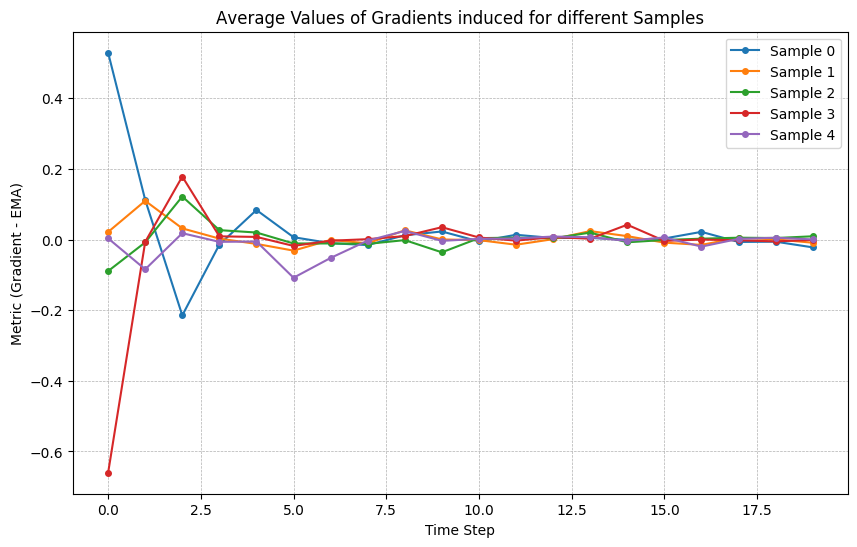

In [143]:
import matplotlib.pyplot as plt
import torch

data=[]

for idx in train_subset.indices[:10]:  # Check the first 10 indices of the subset
    data.append(train_subset.dataset.extra_fields[idx])

# Plot the metric history for each sample with markers
plt.figure(figsize=(10, 6))

for idx, sample in enumerate(data[:5]):  # Use the first 10 samples
    metric_history = [val.item() for val in sample["metric_history"]]
    signal = np.array(metric_history)

    plt.plot(signal, marker='o', label=f'Sample {idx}', markersize=4)  # Add markers to the line

plt.title('Αverage Values of Gradients induced for different Samples')
plt.xlabel('Time Step')
plt.ylabel('Metric (Gradient - EMA)')
plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



High frequencies in the signal may correspond to samples that are highly sensitive to the model's weight updates or represent noisy or challenging patterns.

Indices of top 5 fast-frequency samples: [17593, 22782, 45273, 41826, 17862]


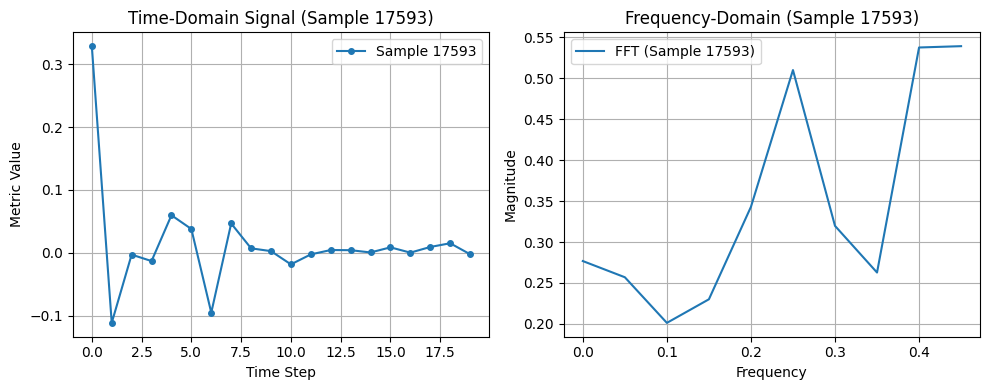

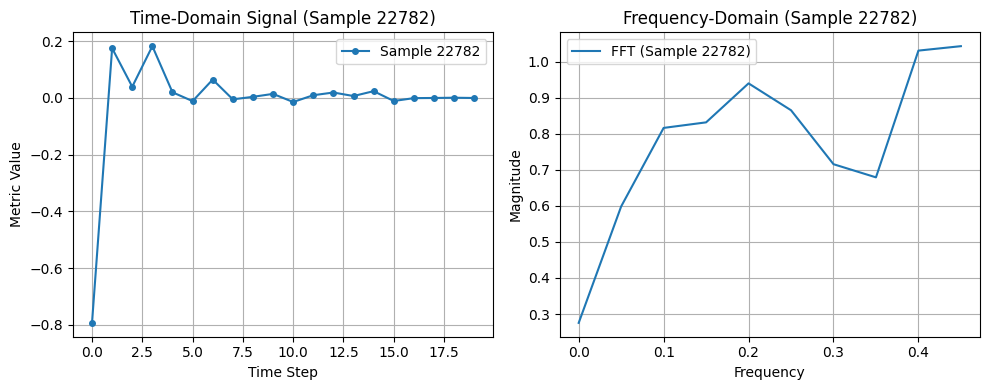

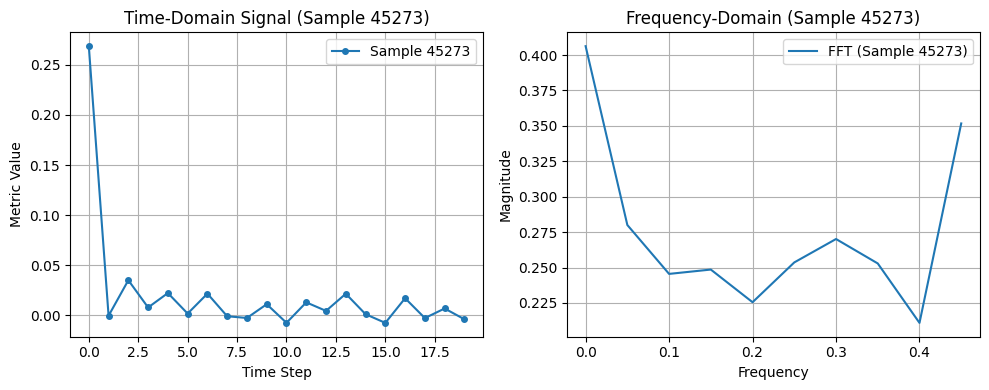

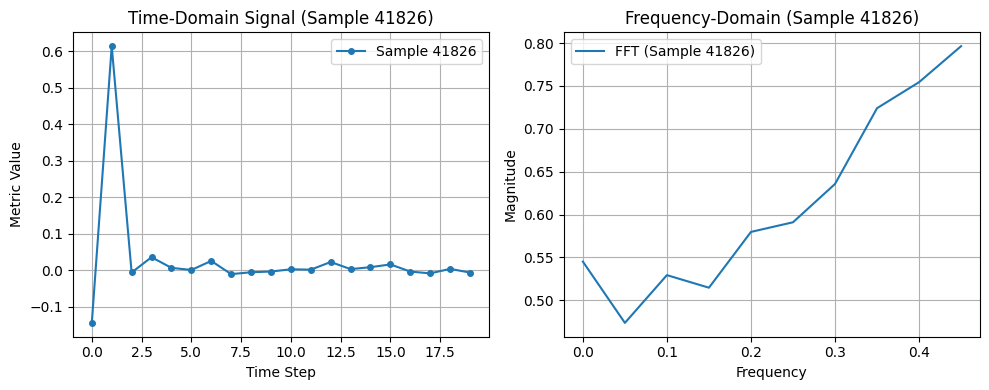

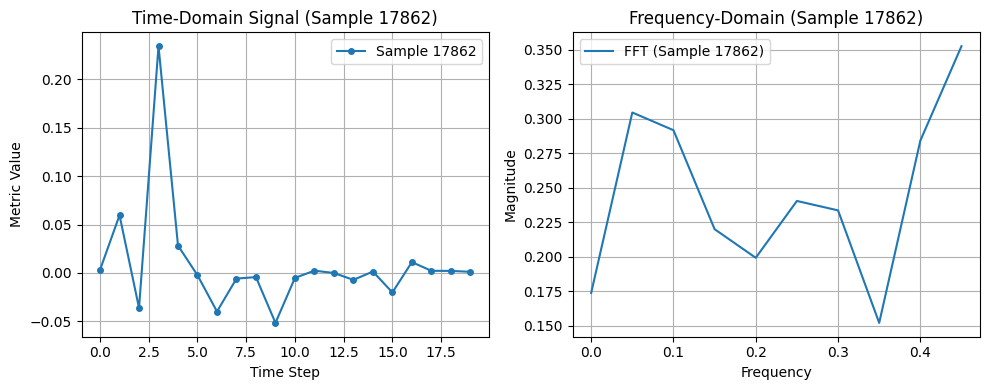

In [141]:
import numpy as np
import heapq  # For efficiently keeping the top 5 fastest samples
import matplotlib.pyplot as plt

# List to store the fastest samples and their indices
fast_frequency_samples = []
fast_frequency_indices = []

# List to store all dominant frequencies and their corresponding samples for sorting
dominant_frequencies = []

for idx in train_subset.indices:  # Loop through all samples in the subset
    metric_history = train_subset.dataset.extra_fields[idx]["metric_history"]
    if len(metric_history) > 1:  # Ensure there's enough data for FFT
        # Convert metric_history to numpy array
        metric_values = np.array([val.item() for val in metric_history])

        # Compute the FFT
        fft_result = np.fft.fft(metric_values)
        freqs = np.fft.fftfreq(len(metric_values))

        # Get the magnitude of FFT components
        fft_magnitude = np.abs(fft_result)

        # Identify the dominant frequency
        dominant_frequency = freqs[np.argmax(fft_magnitude[1:])]  # Ignore DC component (index 0)

        # Store the dominant frequency and corresponding sample
        dominant_frequencies.append((abs(dominant_frequency), idx, metric_values))

# Select the top 5 samples with the highest frequencies
top_5_fastest = heapq.nlargest(5, dominant_frequencies, key=lambda x: x[0])

# Extract the corresponding samples and indices
fast_frequency_samples = [sample[2] for sample in top_5_fastest]
fast_frequency_indices = [sample[1] for sample in top_5_fastest]

# Print indices of the top 5 fast-frequency samples
print("Indices of top 5 fast-frequency samples:", fast_frequency_indices)

# Visualize the time-domain and frequency-domain representations for these samples
for i, (signal, idx) in enumerate(zip(fast_frequency_samples, fast_frequency_indices)):
    plt.figure(figsize=(10, 4))

    # Time-domain plot
    plt.subplot(1, 2, 1)
    plt.plot(signal, label=f"Sample {idx}", marker="o", markersize=4)
    plt.title(f"Time-Domain Signal (Sample {idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)

    # Frequency-domain plot (FFT)
    plt.subplot(1, 2, 2)
    fft_result = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_result)
    freqs = np.fft.fftfreq(len(signal))
    plt.plot(freqs[:len(freqs)//2], fft_magnitude[:len(freqs)//2], label=f"FFT (Sample {idx})")
    plt.title(f"Frequency-Domain (Sample {idx})")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [142]:
import numpy as np
import heapq  # For selecting fastest samples
import matplotlib.pyplot as plt

# Store dominant frequencies for all samples
dominant_frequencies = []

for idx in train_subset.indices:  # Loop through all samples in the subset
    metric_history = train_subset.dataset.extra_fields[idx]["metric_history"]
    if len(metric_history) > 1:  # Ensure there's enough data for FFT
        # Convert metric_history to numpy array
        metric_values = np.array([val.item() for val in metric_history])

        # Compute the FFT
        fft_result = np.fft.fft(metric_values)
        freqs = np.fft.fftfreq(len(metric_values))

        # Get the magnitude of FFT components
        fft_magnitude = np.abs(fft_result)

        # Identify the dominant frequency
        dominant_frequency = abs(freqs[np.argmax(fft_magnitude[1:])])  # Ignore DC component (index 0)

        # Store the dominant frequency and corresponding sample
        dominant_frequencies.append((dominant_frequency, idx))

# Sort samples by dominant frequency
dominant_frequencies.sort(reverse=True, key=lambda x: x[0])  # Sort in descending order of frequency

# Split into top 10% fastest and 10% of the rest
num_samples = len(dominant_frequencies)
top_10_percent_count = int(0.1 * num_samples)
rest_10_percent_count = int(0.1 * num_samples)

top_10_percent = dominant_frequencies[:top_10_percent_count]
rest_10_percent = dominant_frequencies[top_10_percent_count:]

# Randomly sample 10% of the remaining samples
np.random.seed(42)  # For reproducibility
# Extract only the indices from rest_10_percent
rest_10_percent_indices = [sample[1] for sample in rest_10_percent]

# Randomly sample 10% of the remaining indices
rest_10_percent_sample = np.random.choice(rest_10_percent_indices, size=rest_10_percent_count, replace=False)

# Combine the selected samples (top 10% + randomly selected 10%)
selected_indices = [sample[1] for sample in top_10_percent] + list(rest_10_percent_sample)


# Print the number of samples in each category
print(f"Top 10% fastest samples: {len(top_10_percent)}")
print(f"10% randomly selected from the rest: {len(rest_10_percent_sample)}")
print(f"Total selected samples for training: {len(selected_indices)}")

# Create a new dataset containing only the selected samples
selected_dataset = torch.utils.data.Subset(train_subset.dataset, selected_indices)
selected_loader = DataLoader(selected_dataset, batch_size=args.batch_size, shuffle=True)



Top 10% fastest samples: 100
10% randomly selected from the rest: 100
Total selected samples for training: 200


In [113]:
# results_pt_dir = "/content/drive/MyDrive/PatRec_Project_Shared_Folder/results"

# file="MNIST/pt/mnist_experiment_all_samples.pt"

# results_pt_dir = os.path.join(results_pt_dir, file)

# results = torch.load(results_pt_dir)


# # Extract data from results
# its = results["its"]  # Optimization steps
# train_acc = results["train_acc"]  # Training accuracy
# val_acc = results["val_acc"]  # Validation accuracy
# train_loss = results["train_loss"]  # Training loss
# val_loss = results["val_loss"]  # Validation loss

# # Plot Accuracy
# plt.figure()
# plt.plot(its, train_acc, label="train")
# plt.plot(its, val_acc, label="val")
# plt.legend()
# plt.title(f"Accuracy")
# plt.xlabel("Optimization Steps")
# plt.ylabel("Accuracy")
# plt.xscale("log", base=10)
# plt.grid()
# #plt.savefig(f"{results_dir}/acc/acc_{args_label}_lambda_{lamb}_alpha_{alpha}.png", dpi=150)
# #plt.close()

# # Plot Loss
# plt.figure()
# plt.plot(its, train_loss, label="train")
# plt.plot(its, val_loss, label="val")
# plt.legend()
# plt.title(f"Loss")
# plt.xlabel("Optimization Steps")
# plt.ylabel("Loss")
# plt.xscale("log", base=10)
# plt.grid()
# #plt.savefig(f"{results_dir}/loss/loss_{args_label}_lambda_{lamb}_alpha_{alpha}.png", dpi=150)
# #plt.close()

# print("Plots saved successfully.")